## To-do list
- metrics functions
- check for directories structure (model for prediction, databases, saving directory for the drawdown/VaR/etc plots, backup directory for model, backup directory for plots)
- import metrics (VaR, cVaR, drawdown, etc.) functions from metrics module
- functions module maybe?
- Binance access and etc (copy from Touring)
- Copy keys.py explanation from Touring
- Two main fund strategies: (1) passive - trade on 1st of each month, keep in basked the 10 crytpos with the most market cap; (2) active - trade every week based on predicted returns for the next week
- Let the user define how many assets to invest into
- Tem que usar sentiment analysis de twitter, reddit, google news, etc. Trabalhar com dados em T+0 e em T-1, T-2, T-3...
- Faz defasagem para RSI também
- Ver se tem algum dado de taxa de juros americana/europeia/chinesa(?)/japonesa diária
- Ou algum dado 'mundial' para ajudar na intepretação dos dados
- Também trabalhar com defasagens (1, 2, 3...) nesses dados
- When using Markovwitz, use pypfopt package


In [19]:
#------ Import basic packages
#import matplotlib.pyplot as plt
#import seaborn as sns
#import smtplib  # Needed for the e-mail reports
#import binance.enums  # Responsible for trading

#import numpy as np
import pandas as pd
#import pandas_ta
from functions import *
pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [193]:
#from metrics import mvcriterion, optim_mvcrit

#wallet = binance_wallet()


# Set the params for the fetch_data function
params = {'days':365*2,
          'interval':'1d',
          'rsi':20,
          'bbands':20,
          'roll':13}

# fetch_data() checks for the most liquid cryptos, fetches the data from
# Binance given the params above and estimates the technical indicators
data = fetch_data(**params)

# Now we need to estimate the optimal number of clusters to
# allocate our resources
clusters = estimate_kmeans(data.rsi)

# Sets the params for the clustering function used with apply below
params2 = {'clusters':clusters}

# Groups the data and applies the clustering
data = data.dropna().groupby('time', group_keys=False).apply(clustering, **params2)

Checking for trading pairs...
The resources directory exists, checking for trade pairs file.
Trading pairs file 'pairs_202507.csv' found, checking version.
Trading pairs file is up to date.
Loading pairs.
Pairs successfully loaded.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All done.
Requesting informations from Binance.
Request successful. Splitting data...
All 

In [ ]:
import matplotlib.pyplot as plt
for i in data.index.get_level_values('time').unique().to_list():
    g = data.xs(i, level=0)
    plt.title(f'Two-week period ending in {i}')
    plot_clusters(g)

In [ ]:
plot_clusters(data, attr_1='atr', attr_2='rsi')

In [215]:
def clustering(df, metric='rsi', clusters=None):
    """
    Description: performs the clustering of the data, based on estimate_kmeans() results.

    Input: df (pandas DataFrame), the data to perform the clustering;
            metric (str), metric to estimate the centroids. Defaults to 'rsi';
            clusters (int), either user-defined or the results from estimate_kmeans()

    Output: df (pandas DataFrame), the clustered DataFrame
    """
    from sklearn.cluster import KMeans
    import numpy as np
    
    temp = pd.Series(df.columns == metric)
    num = temp[temp.index == True].index[0]
    feat = int(num)

    # Set target values
    target_values = [30, 45, 55, 70]

    # Calculate centroids
    centroids = np.zeros((len(target_values), len(df.columns)))
    centroids[:, feat] = target_values
    
    df['cluster_num'] = KMeans(n_clusters=clusters,
                               random_state=1,
                               init='random').fit(df).labels_
    
    return df

    

In [214]:
data[data.rsi > 65]

close         rsi      bb_low      bb_mid  \
time       asset                                                          
2024-08-25 TRXUSDT       0.16160000 68.77584510  0.10654922  0.13164649   
2024-09-22 SUIUSDT       1.53480000 74.60976513  0.51112325  0.74105077   
2024-10-06 SUIUSDT       2.01730000 72.87955211  0.85395712  0.97980023   
2024-10-20 DOGEUSDT      0.14367000 70.79331643  0.08751731  0.11144939   
2024-11-17 ADAUSDT       0.73250000 77.07958789  0.20190767  0.39804859   
           BTCUSDT   90464.08000000 73.50342133 11.05454567 11.27656335   
           DOGEUSDT      0.37113000 76.55316559  0.07652441  0.22796306   
           SOLUSDT     239.79000000 72.42614042  5.01751546  5.27631287   
           SUIUSDT       3.69920000 76.82821458  0.91892153  1.29654271   
           TRXUSDT       0.20220000 73.44114993  0.13615038  0.15992831   
           XRPUSDT       1.11370000 82.94240441  0.27225682  0.50413535   
2024-12-01 ADAUSDT       1.20220000 81.40953800  0.43760903  0.63598407   
           AVAXUSDT     52.27000000 76.55118652  3.42368477  3.69307318   
           BTCUSDT   95840.62000000 65.19161469 11.38011096 11.45169568   
           DOGEUSDT      0.42457000 68.75016766  0.30130033  0.33521666   
           ETHUSDT    3643.42000000 65.32240181  7.98129833  8.11458988   
           LINKUSDT     25.23000000 79.46101159  2.55957903  2.85687159   
           LTCUSDT     132.93000000 76.54137303  4.30729413  4.55595317   
           SHIBUSDT      0.00002992 67.55728505  0.00002216  0.00002567   
           TRXUSDT       0.22100000 70.36111847  0.16530403  0.18214035   
           XRPUSDT       2.72450000 93.63650197  0.47700923  0.85807143   
2024-12-15 BTCUSDT  106058.66000000 69.06866203 11.44375345 11.50186960   
           LINKUSDT     28.73000000 68.46730222  2.89032966  3.20607533   
           XRPUSDT       2.48410000 67.46174012  0.96591147  1.18228282   
2025-05-18 BTCUSDT  105573.74000000 67.14324931 11.43566557 11.51915756   
           ETHUSDT    2528.14000000 66.58203708  7.37804754  7.69738482   
2025-07-13 BTCUSDT  119841.18000000 70.95266173 11.53384137 11.61286754   
           ETHUSDT    3013.62000000 68.09193127  7.71531369  7.87208787   
           SUIUSDT       3.88920000 65.93643183  1.22871577  1.38674158   
           TRXUSDT       0.30250000 68.45987446  0.23590828  0.25143260   
           XLMUSDT       0.46360000 82.64930330  0.13523032  0.24713822   
           XRPUSDT       2.95820000 76.94247821  1.06768633  1.20981073   
2025-07-27 BNBUSDT     787.97000000 80.51157998  6.43994262  6.55689460   
           DOGEUSDT      0.24870000 65.39831281  0.13065373  0.18936809   
           ETHUSDT    3618.67000000 73.70357428  7.74952572  8.03524010   
           LINKUSDT     18.37000000 65.51094265  2.58087230  2.83219111   
           LTCUSDT     114.11000000 68.48326283  4.38576411  4.59668676   
           XLMUSDT       0.43850000 65.24276054  0.18164303  0.32256591   
           XRPUSDT       3.30430000 69.00236265  1.09646130  1.34848581   

                        bb_high         atr       macd  return_1m  return_2m  \
time       asset                                                               
2024-08-25 TRXUSDT   0.15674375 -0.02257407 1.23987127 0.08409996 0.06039856   
2024-09-22 SUIUSDT   0.97097829 -0.56402321 0.98018120 0.28707301 0.20006569   
2024-10-06 SUIUSDT   1.10564335 -0.14948291 1.14246520 0.43452608 0.18754757   
2024-10-20 DOGEUSDT  0.13538147 -0.56656472 0.51188149 0.15300309 0.08102961   
2024-11-17 ADAUSDT   0.59418951  0.40616190 2.49185693 0.42465719 0.19128612   
           BTCUSDT  11.49858104  0.61130348 2.79214735 0.15872570 0.09319980   
           DOGEUSDT  0.37940171  1.73295222 4.35282968 0.60723723 0.36130434   
           SOLUSDT   5.53511028  0.67280351 2.29303512 0.20126611 0.13331874   
           SUIUSDT   1.67416389  0.87163087 2.99122573 0.35674770 0.24363148   
           TRXUSDT   0.18370624  0.07754427 1.37678659 0.12982970 0.073421

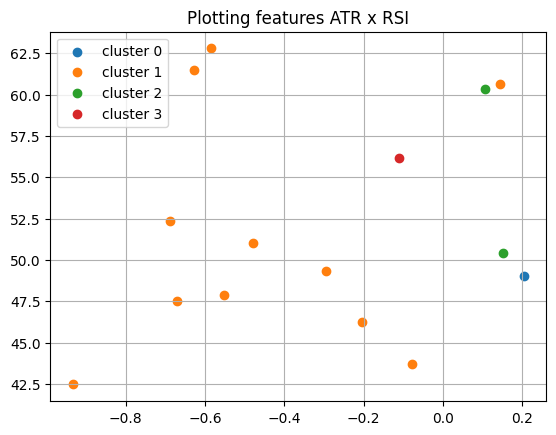

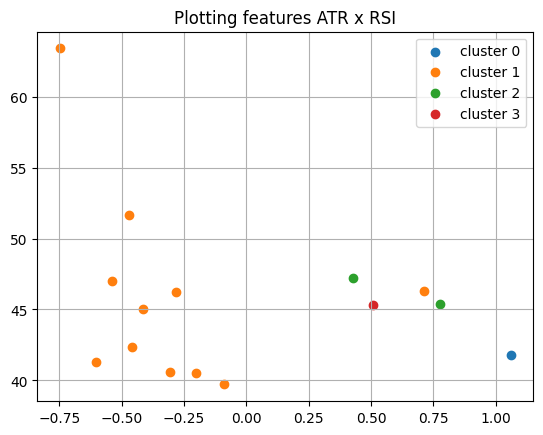

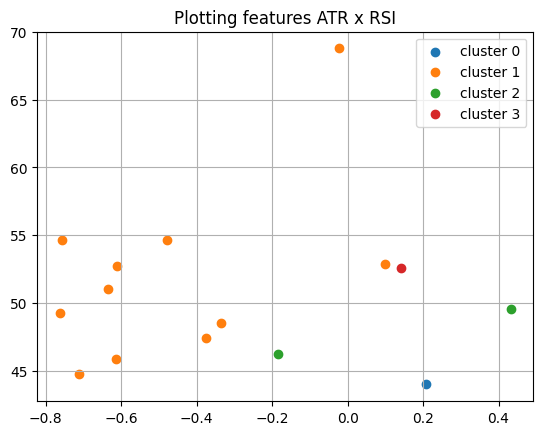

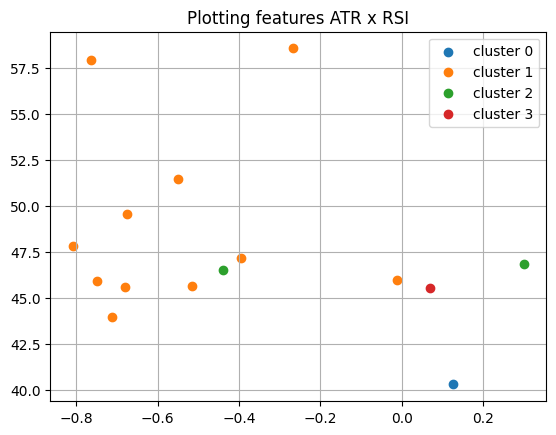

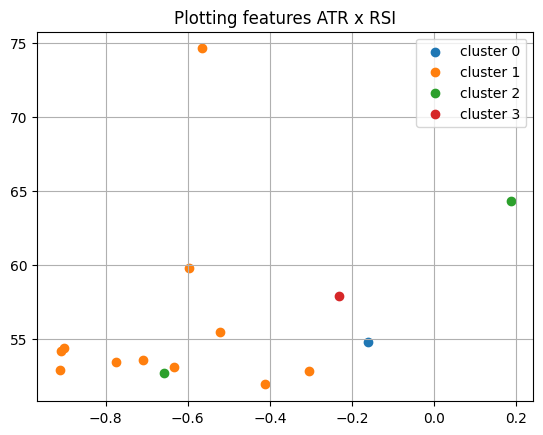

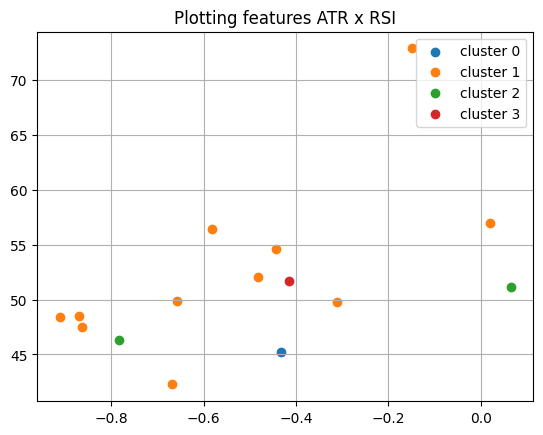

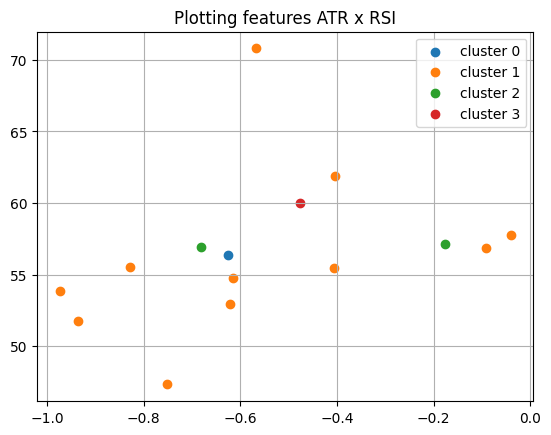

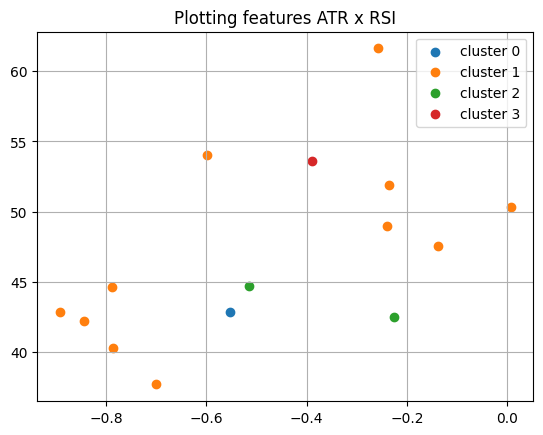

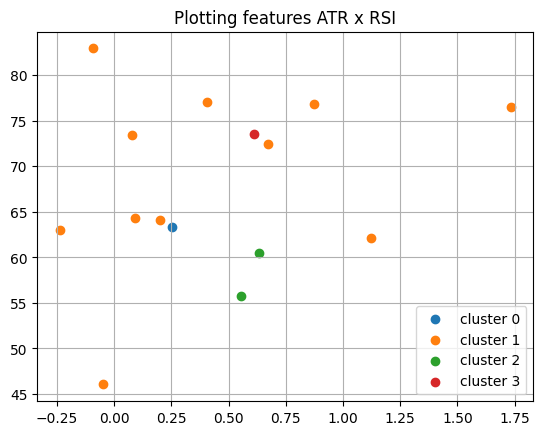

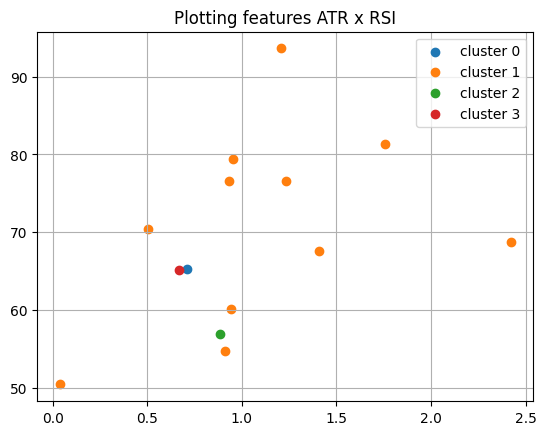

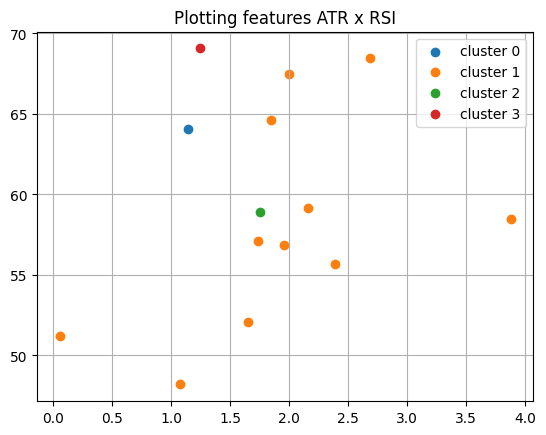

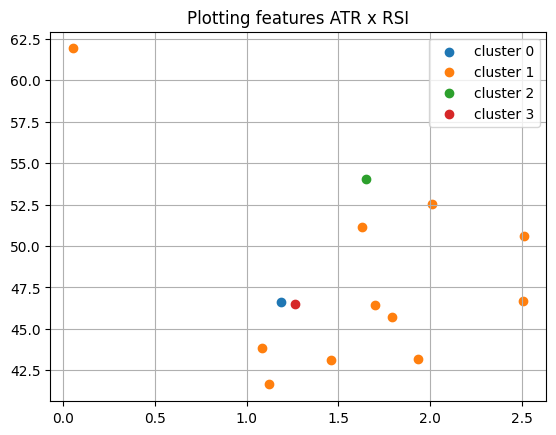

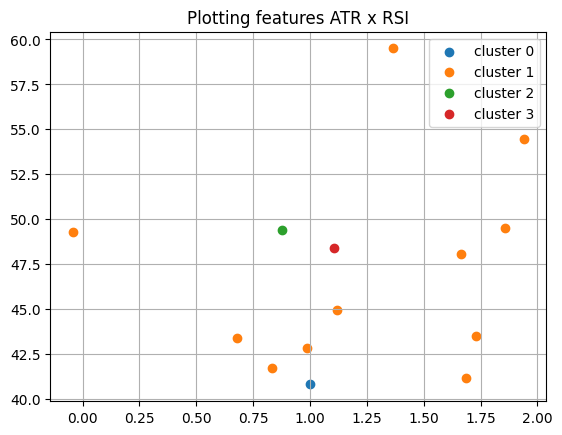

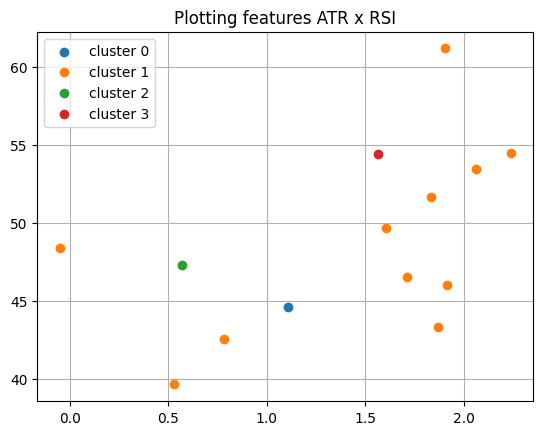

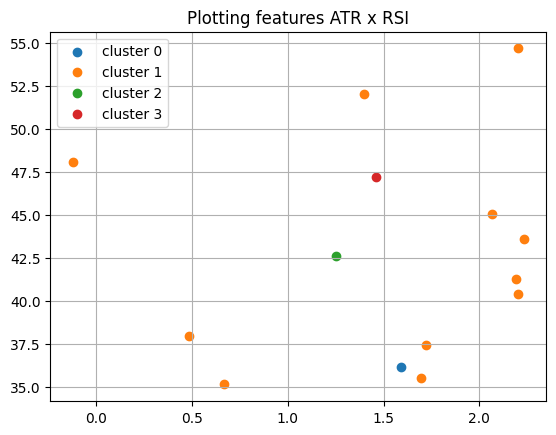

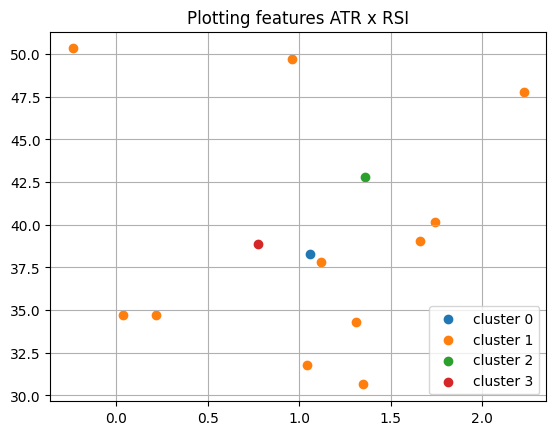

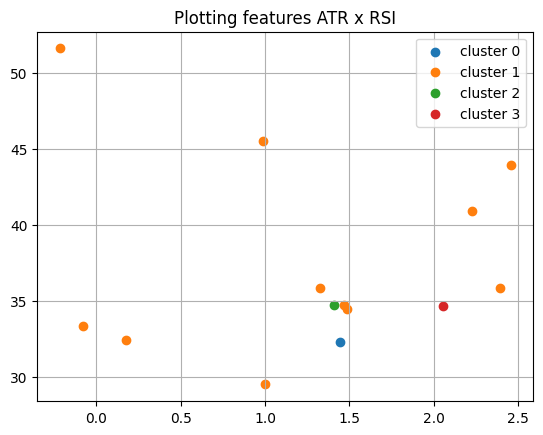

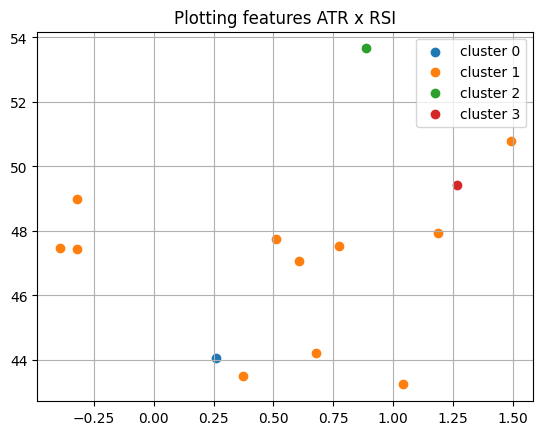

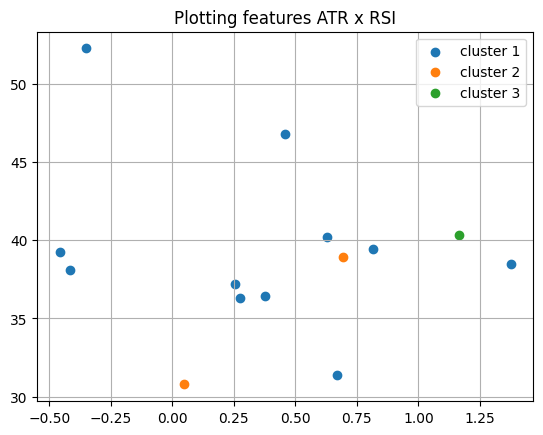

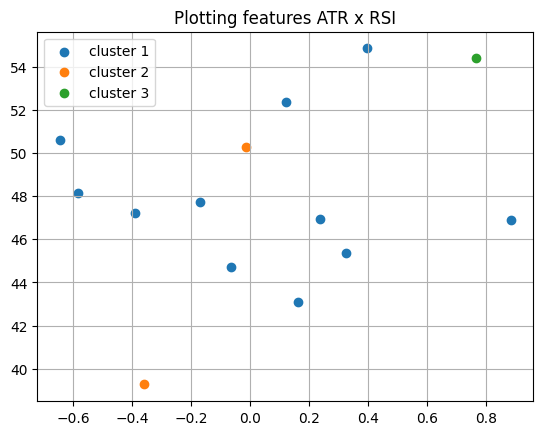

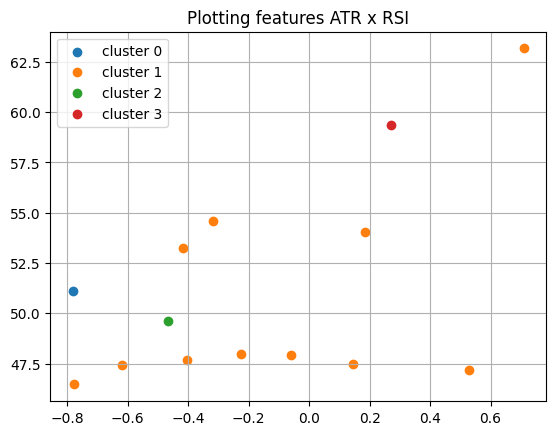

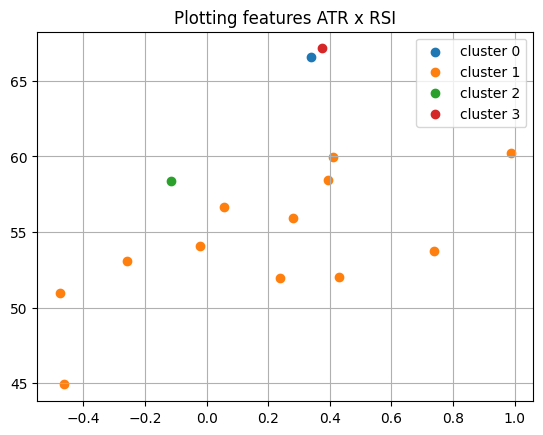

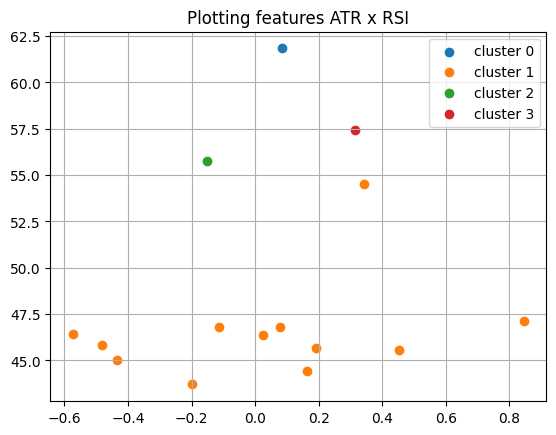

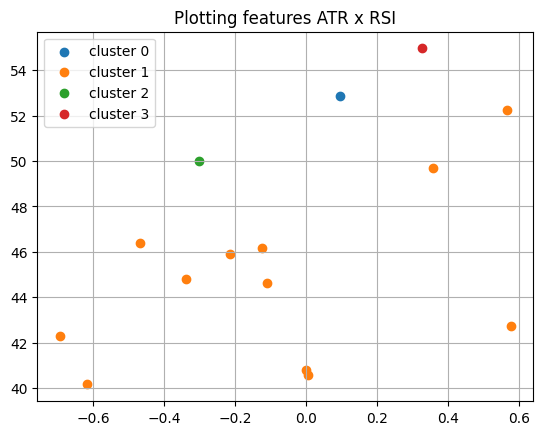

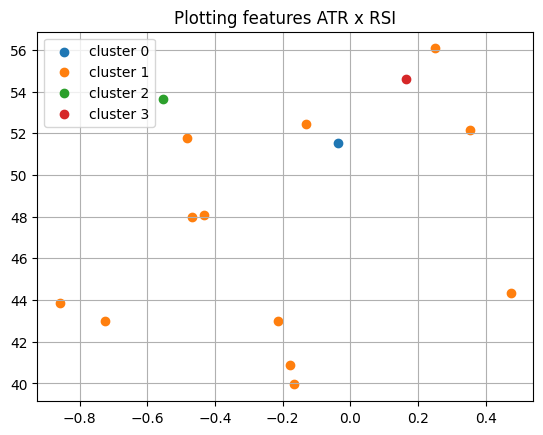

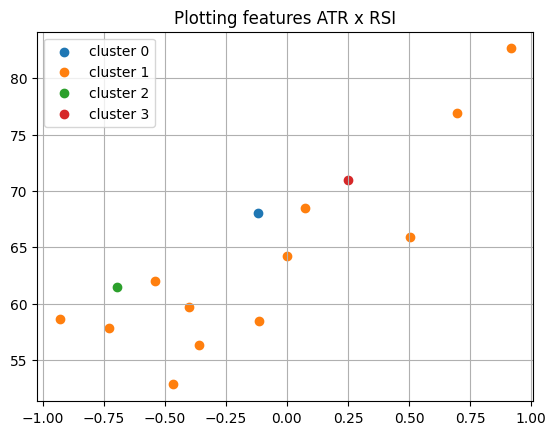

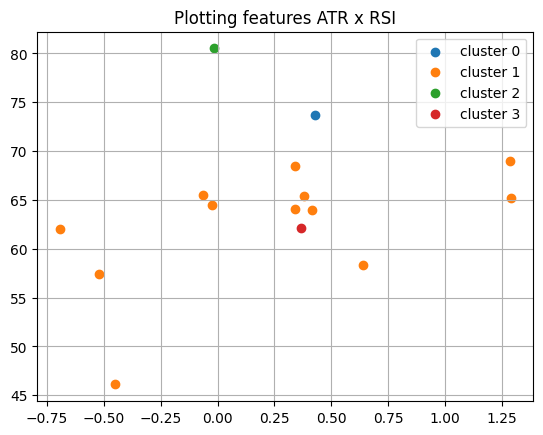

In [216]:
thiago = clustering(data, clusters=clusters)

for i in thiago.index.get_level_values('time').unique().to_list():
    g = thiago.xs(i)
    plot_clusters(g)

### Down here is the original functions to estimate k and to perform the clustering: